# Backtest Of Exiting the Market During a Downtrend MACD Signal

## Import packages

In [48]:
import os
import sys
import json
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

In [49]:
parent_dir = os.path.join(os.getcwd(),"../src")
sys.path.insert(0, parent_dir)
from semi_utils import sql_queries as sqlq

### Focus on Soxx

In [50]:
engine = sqlq.get_sql_engine(os.path.join(os.getcwd(), '..','data', 'semi.db'))
soxx = pd.read_sql('SELECT * FROM soxx', engine)

soxx

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2001-07-13 00:00:00.000000,19.982117,20.338645,19.506747,20.078850,603300,0.000,0.0,0.0
1,2001-07-16 00:00:00.000000,19.719551,19.774828,18.915293,18.915293,180000,0.000,0.0,0.0
2,2001-07-17 00:00:00.000000,18.779874,19.691921,18.766055,19.691921,287100,0.000,0.0,0.0
3,2001-07-18 00:00:00.000000,19.097718,19.238671,18.876616,18.876616,301800,0.000,0.0,0.0
4,2001-07-19 00:00:00.000000,20.009754,20.092667,19.678101,19.678101,405000,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5833,2024-09-20 00:00:00.000000,224.164191,225.022103,219.904559,223.126709,4550800,0.000,0.0,0.0
5834,2024-09-23 00:00:00.000000,224.204095,225.002155,222.408464,223.994598,2454200,0.000,0.0,0.0
5835,2024-09-24 00:00:00.000000,225.999726,228.074675,223.425990,226.707993,4314700,0.000,0.0,0.0
5836,2024-09-25 00:00:00.000000,225.979996,229.770004,225.850006,228.270004,2191200,0.552,0.0,0.0


In [51]:
engine.dispose()

#### Clean the dataframe

In [52]:

soxx.columns = soxx.columns.str.lower()
soxx.drop(columns = ['high', 'low', 'dividends', 'stock splits', 'capital gains', 'volume'], inplace = True)
soxx['date'] = pd.to_datetime(soxx['date']).dt.strftime('%Y-%m-%d')
soxx['date'] = pd.to_datetime(soxx['date'])
soxx[:3]

,date,open,close
0,2001-07-13,19.982117,20.078850
1,2001-07-16,19.719551,18.915293
2,2001-07-17,18.779874,19.691921


#### Add new columns

In [53]:
def get_returns(soxx):
    soxx['intraday_p_change'] = soxx.close - soxx.open
    soxx.loc[1:,'day_p_change'] = soxx.close - soxx.close.shift(1)
    soxx.loc[1:,'day_return'] = (soxx.day_p_change / soxx.close.shift(1))

    # Add a 'total_return' column which is the cumulative product of (1 + day_return)
    soxx['total_return'] = (1 + soxx['day_return']).cumprod()

    # Calculate moving averages for 9, 50, 90, and 200 days
    #soxx['sma_9'] = soxx['close'].rolling(window=9).mean()
    #soxx['sma_50'] = soxx['close'].rolling(window=50).mean()
    #soxx['sma_90'] = soxx['close'].rolling(window=90).mean()
    #soxx['sma_200'] = soxx['close'].rolling(window=200).mean()

    # Calculate exponential moving averages (EMAs) with smoothing factor of 2
    period_size = 3
    soxx['ema_50'] = soxx['close'].ewm(span=50*period_size, adjust=False).mean()
    soxx['ema_90'] = soxx['close'].ewm(span=90*period_size, adjust=False).mean()
    soxx['ema_200'] = soxx['close'].ewm(span=200*period_size, adjust=False).mean()

    # Calculate the macd
    soxx['macd'] = soxx.ema_50 - soxx.ema_90

    # Calculate the signal
    soxx['signal'] = soxx['macd'].ewm(span=9*0.5*period_size, adjust=False).mean()

    soxx['trigger'] = (soxx['macd'] < soxx['signal']).astype(int)

    # add a day return for strategy_1: go to cash when macd crosses below its 9 period moving average
    soxx['strategy_1_day_return'] = (1 - soxx.trigger)*soxx.day_return
    soxx['strategy_1_total_return'] = (1 + soxx['strategy_1_day_return']).cumprod()

    return soxx

soxx = get_returns(soxx)


#soxx[:6]

#### Get the Annualised Total Returns

In [54]:
# Function to calculate annualized return
def calculate_annualized_return(cum_return, days, periods_per_year=365):
    #print(days)
    return ((cum_return) ** (periods_per_year / days)) - 1

# Assuming 'soxx' DataFrame and 'total_return' and 'strategy_1_total_return' columns are already present
# Calculate the number of days up to each date in terms of index steps
soxx['days'] = np.arange(len(soxx))  # Simple integer index, so days are just the index itself

# Calculate annualized total return for no strategy
soxx.loc[1:,'annualized_return_no_strategy'] = soxx[1:].apply(
    lambda row: calculate_annualized_return(row['total_return'], row['days']),
    axis=1
)

# Calculate annualized total return for strategy_1
soxx.loc[1:,'annualized_return_strategy_1'] = soxx[1:].apply(
    lambda row: calculate_annualized_return(row['strategy_1_total_return'], row['days']),
    axis=1
)

# Drop the 'days' column if no longer needed
soxx.drop(columns='days', inplace=True)

# Get the annualised TRs for Each
tr = round(list(soxx.annualized_return_no_strategy)[-1],2)
strategy_1_tr = round(list(soxx.annualized_return_strategy_1)[-1],2)

# Display the first few rows to verify
#display(soxx[['date','total_return', 'strategy_1_total_return', 'annualized_return_no_strategy', 'annualized_return_strategy_1']].tail())



#### Visualise price performance

#### Using Matplotlib (Standard)

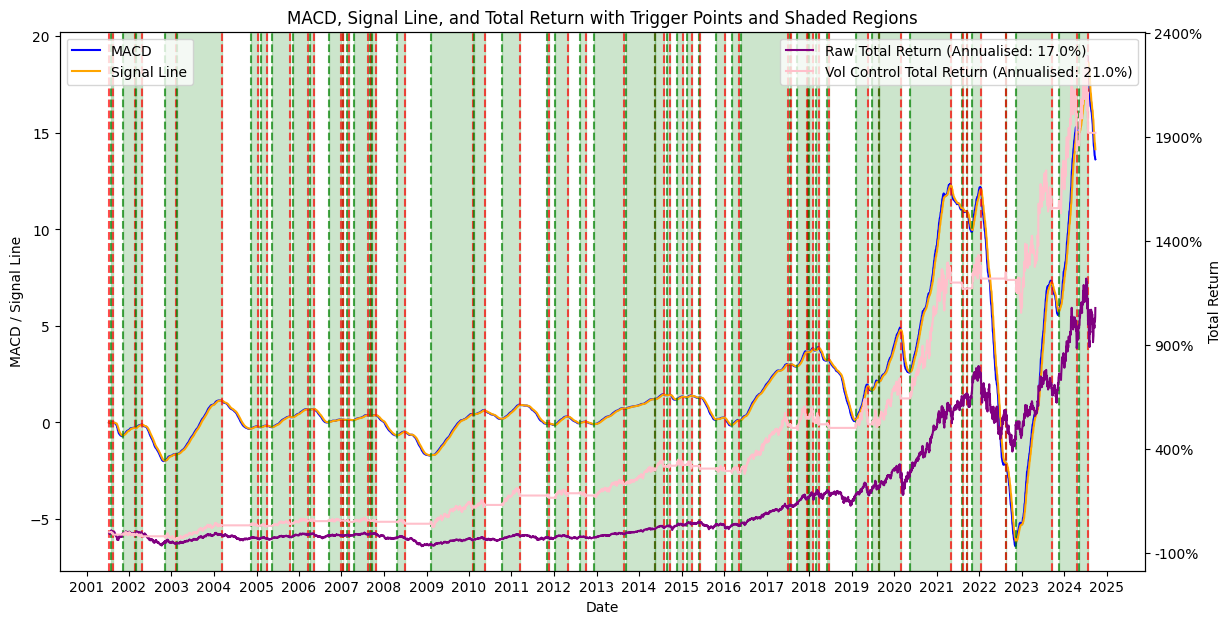

In [55]:
def macd_vis(soxx, figs_dir = "../docs/subpages_1"):
    # Ensure 'date' is set as the x-axis for plotting
    x_dates = soxx['date']
    
    # Create the plot with a secondary y-axis
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Plot MACD and Signal line on the primary y-axis (ax1)
    ax1.plot(x_dates, soxx['macd'], label='MACD', color='blue')
    ax1.plot(x_dates, soxx['signal'], label='Signal Line', color='orange')
    
    # Find where the trigger changes (from 1 to 0 or 0 to 1)
    trigger_changes = soxx['trigger'].diff().fillna(0)
    
    # Initialize variables for tracking green-red pairs
    green_start = None
    
    # Add vertical lines and highlight background
    for i in range(1, len(soxx)):
        if trigger_changes.iloc[i] == -1:  # Trigger changed from 1 to 0
            # Green line for sell signal
            ax1.axvline(x=x_dates.iloc[i], color='green', linestyle='--', alpha=0.7)
            green_start = x_dates.iloc[i]  # Mark the start of the green-red region
        elif trigger_changes.iloc[i] == 1:  # Trigger changed from 0 to 1
            # Red line for buy signal
            ax1.axvline(x=x_dates.iloc[i], color='red', linestyle='--', alpha=0.7)
            if green_start is not None:
                # Shade the region between the green and red lines
                ax1.axvspan(green_start, x_dates.iloc[i], color='green', alpha=0.2)
                green_start = None  # Reset the start marker
    
    # Labels and title for primary axis
    ax1.set_xlabel('Date')
    ax1.set_ylabel('MACD / Signal Line')
    ax1.set_title('MACD, Signal Line, and Total Return with Trigger Points and Shaded Regions')
    ax1.legend(loc='upper left')

    # Set x-axis ticks to be yearly
    ax1.xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to be at the start of each year
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as year only

    # Create a secondary y-axis to plot total return
    ax2 = ax1.twinx()
    ax2.plot(x_dates, soxx['total_return'], label=f'Raw Total Return (Annualised: {tr*100}%)', color='purple')
    ax2.plot(x_dates, soxx['strategy_1_total_return'], label=f'Vol Control Total Return (Annualised: {strategy_1_tr*100}%)', color='pink')
    # Convert to %
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{(x - 1) * 100:.0f}%'))
    ax2.set_ylabel('Total Return')
    
    # Add a legend for the secondary axis
    ax2.legend(loc='upper right')

    # Save it out
    plt.savefig(os.path.join(figs_dir, "macd_vis.svg"))

    # Display the plot
    plt.show()

# Call the function with the soxx DataFrame
macd_vis(soxx)


#### Using Plotly

In [56]:

def macd_vis_plotly(soxx, figs_dir="../docs/subpages_1"):

    soxx = soxx.copy()
    

    # Ensure 'date' is in datetime format

    soxx = get_returns(soxx)
    # Calculate annualized returns based on the last entry in 'total_return' and 'strategy_1_total_return'
    total_return_last = soxx['total_return'].iloc[-1]
    strategy_1_return_last = soxx['strategy_1_total_return'].iloc[-1]

    # Calculate the number of years in the data
    total_days = (soxx['date'].iloc[-1] - soxx['date'].iloc[0]).days
    years = total_days / 365.25

    # Annualized returns formula
    tr_annualized = (total_return_last ** (1 / years) - 1) * 100
    strategy_1_tr_annualized = (strategy_1_return_last ** (1 / years) - 1) * 100

    # Create traces for MACD, Signal, and Total Return
    macd_trace = go.Scatter(x=soxx['date'], y=soxx['macd'] , mode='lines', name='MACD', line=dict(color='blue'))
    signal_trace = go.Scatter(x=soxx['date'], y=soxx['signal'], mode='lines', name='Signal Line', line=dict(color='orange'))
    
    total_return_trace = go.Scatter(x=soxx['date'], y=soxx['total_return'], mode='lines', 
                                    name=f'Raw Total Return (Annualised: {tr_annualized:.2f}%)', yaxis='y2', line=dict(color='purple'))
    strategy_return_trace = go.Scatter(x=soxx['date'], y=soxx['strategy_1_total_return'], mode='lines', 
                                       name=f'Vol Control Total Return (Annualised: {strategy_1_tr_annualized:.2f}%)', yaxis='y2', line=dict(color='pink'))

    # Create vertical lines where trigger changes
    trigger_changes = soxx['trigger'].diff().fillna(0)
    vertical_lines = []
    for i in range(1, len(soxx)):
        if trigger_changes.iloc[i] == -1:
            vertical_lines.append(dict(type='line', x0=soxx['date'].iloc[i], x1=soxx['date'].iloc[i],
                                       y0=0, y1=1, yref='paper', line=dict(color='green', dash='dash')))
        elif trigger_changes.iloc[i] == 1:
            vertical_lines.append(dict(type='line', x0=soxx['date'].iloc[i], x1=soxx['date'].iloc[i],
                                       y0=0, y1=1, yref='paper', line=dict(color='red', dash='dash')))

    # Create the layout for the plot
    layout = go.Layout(
        title='MACD, Signal Line, and Total Return with Interactive Features',
        xaxis=dict(title='Date', rangeslider=dict(visible=True), type='date'),
        yaxis=dict(title='MACD / Signal Line'),
        yaxis2=dict(title='Total Return (%)', overlaying='y', side='right', tickformat='.0%'),
        shapes=vertical_lines,  # Add vertical lines
        legend=dict(x=0.01, y=0.99, bordercolor="Black", borderwidth=1)
    )

    # Create the figure and add traces
    fig = go.Figure(data=[macd_trace, signal_trace, total_return_trace, strategy_return_trace], layout=layout)

    # Save the figure as an HTML file
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)  # Ensure the directory exists
    fig_html_path = os.path.join(figs_dir, "macd_vis_plotly.html")
    fig.write_html(fig_html_path)

    fig.show()
    # Return the path to the saved file
    return None

# Call the function with the soxx DataFrame
macd_vis_plotly(soxx[-1500:])


In [67]:
# Add imports
from dash import dcc, html
from dash.dependencies import Input, Output

app = dash.Dash(__name__)

# Initialize layout
app.layout = html.Div([
    dcc.Checklist(
        id='series-toggle',
        options=[
            {'label': 'Show MACD', 'value': 'macd'},
            {'label': 'Show Signal Line', 'value': 'signal'},
            {'label': 'Show Raw Total Return', 'value': 'raw_return'},
            {'label': 'Show Vol Control Total Return', 'value': 'vol_control'},
            {'label': 'Show Entry/Exit Lines', 'value': 'vertical_lines'},
        ],
        value=['macd', 'signal', 'raw_return', 'vol_control', 'vertical_lines'],  # Default values
        inline=True
    ),
    dcc.Graph(id='macd-graph'),
    dcc.RangeSlider(
        id='date-range-slider',
        min=0,
        max=len(soxx) - 1,
        value=[0, len(soxx) - 1],
        step=1,
        marks={i: str(date.year) for i, date in enumerate(soxx['date']) if (i == 0 or date.year != soxx['date'].iloc[i - 1].year)}
    )
])

@app.callback(
    Output('macd-graph', 'figure'),
    [Input('date-range-slider', 'value'),
     Input('series-toggle', 'value')]
)
def update_graph(selected_range, selected_series):
    start_idx = int(selected_range[0])
    end_idx = int(selected_range[1])

    filtered_soxx = soxx.iloc[start_idx:end_idx + 1].copy()
    filtered_soxx = get_returns(filtered_soxx)

    total_return_last = filtered_soxx['total_return'].iloc[-1]
    strategy_1_return_last = filtered_soxx['strategy_1_total_return'].iloc[-1]

    total_days = (filtered_soxx['date'].iloc[-1] - filtered_soxx['date'].iloc[0]).days
    years = total_days / 365.25 if total_days > 0 else 1

    tr_annualized = (total_return_last ** (1 / years) - 1) * 100
    strategy_1_tr_annualized = (strategy_1_return_last ** (1 / years) - 1) * 100

    # Create traces for MACD, Signal, and Total Return based on selected series
    traces = []
    if 'macd' in selected_series:
        macd_trace = go.Scatter(x=filtered_soxx['date'], y=filtered_soxx['macd'], mode='lines', name='MACD', line=dict(color='blue'))
        traces.append(macd_trace)

    if 'signal' in selected_series:
        signal_trace = go.Scatter(x=filtered_soxx['date'], y=filtered_soxx['signal'], mode='lines', name='Signal Line', line=dict(color='orange'))
        traces.append(signal_trace)

    if 'raw_return' in selected_series:
        total_return_trace = go.Scatter(
            x=filtered_soxx['date'],
            y=filtered_soxx['total_return'],
            mode='lines',
            name=f'Raw Total Return (Annualised: {tr_annualized:.2f}%)',
            yaxis='y2',
            line=dict(color='purple')
        )
        traces.append(total_return_trace)

    if 'vol_control' in selected_series:
        strategy_return_trace = go.Scatter(
            x=filtered_soxx['date'],
            y=filtered_soxx['strategy_1_total_return'],
            mode='lines',
            name=f'Vol Control Total Return (Annualised: {strategy_1_tr_annualized:.2f}%)',
            yaxis='y2',
            line=dict(color='pink')
        )
        traces.append(strategy_return_trace)

    # Create vertical lines based on selection
    vertical_lines = []
    if 'vertical_lines' in selected_series:
        trigger_changes = filtered_soxx['trigger'].diff().fillna(0)
        for i in range(1, len(filtered_soxx)):
            if trigger_changes.iloc[i] == -1:
                vertical_lines.append(dict(type='line', x0=filtered_soxx['date'].iloc[i], x1=filtered_soxx['date'].iloc[i],
                                           y0=0, y1=1, yref='paper', line=dict(color='green', dash='dash')))
            elif trigger_changes.iloc[i] == 1:
                vertical_lines.append(dict(type='line', x0=filtered_soxx['date'].iloc[i], x1=filtered_soxx['date'].iloc[i],
                                           y0=0, y1=1, yref='paper', line=dict(color='red', dash='dash')))

    # Create the layout for the plot
    layout = go.Layout(
        title='MACD, Signal Line, and Total Return with Interactive Features',
        xaxis=dict(title='Date', rangeslider=dict(visible=True), type='date'),
        yaxis=dict(title='MACD / Signal Line'),
        yaxis2=dict(title='Total Return (%)', overlaying='y', side='right', tickformat='.0%'),
        shapes=vertical_lines,  # Add vertical lines if selected
        legend=dict(x=1.1, y=1),
    )

    # Create the figure and add traces
    fig = go.Figure(data=traces, layout=layout)

    return fig

if __name__ == '__main__':
    app.run_server(debug=True, port=8050)
